In [5]:
import os
import librosa
import matplotlib
import scipy 
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from scipy.signal import lfilter
import soundfile as sf
from noisereduce import reduce_noise
import phast

import plotting
import utils

In [6]:
def pre_emphasis(signal: np.ndarray, factor: float = 0.97):
    return np.append(signal[0], signal[1:] - (factor * signal[:-1]))

def bandpass(signal, fs, f_low = 340, f_high = 2700):
    sos = scipy.signal.butter(8, [f_low, f_high], btype='band', fs=fs, output='sos')
    return scipy.signal.sosfilt(sos, signal)

def lowpass(signal, fs, f_high = 2700):
    sos = scipy.signal.butter(8, f_high, btype='low', fs=fs, output='sos')
    return scipy.signal.sosfilt(sos, signal)

def highpass(signal, fs, f_low = 2700):
    sos = scipy.signal.butter(8, f_low, btype='high', fs=fs, output='sos')
    return scipy.signal.sosfilt(sos, signal)
    
def plot_spectrogram(audio_signal, fs, fig = None, ax = None, fmin = 150, fmax = 20000):
    if fig is None:
        fig, ax = plt.subplots()
        
    S = librosa.feature.melspectrogram(y=audio_signal, sr=fs, fmin=fmin, fmax=fmax)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',
                            y_axis='mel', sr=fs,
                            fmax=8000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')

In [7]:
PATH = "emodb_happy.wav"
NAME = os.path.basename(PATH).split(".")[0]

audio_signal, fs = librosa.load(PATH, sr=int(44.1*1e3))
dt = 1 / fs
n = len(audio_signal)
t = np.arange(n) * dt
duration = n * dt

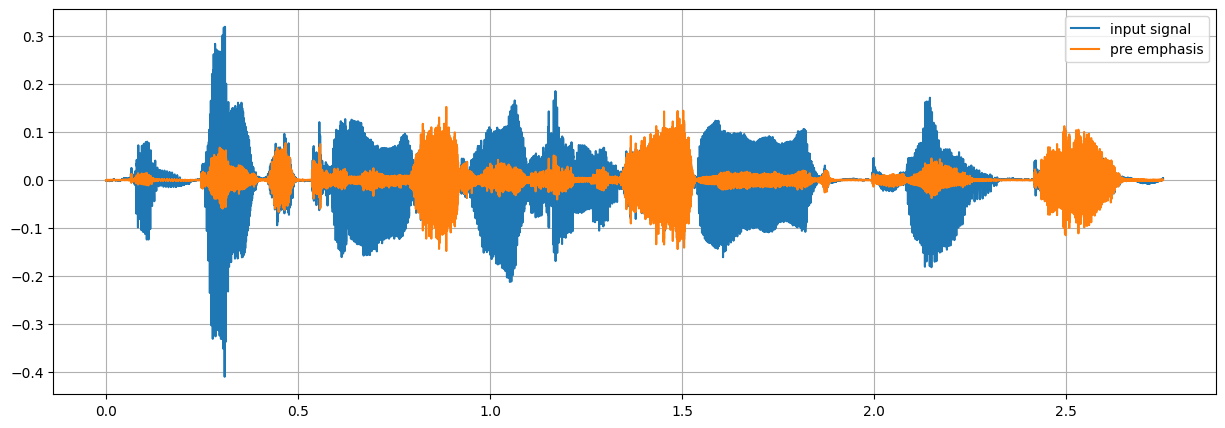

In [8]:
pre_emph = pre_emphasis(audio_signal)
f, ax = plt.subplots(figsize=(15, 5))
ax.plot(t, audio_signal, label="input signal")
ax.plot(t, pre_emph, label="pre emphasis")
ax.grid()
ax.legend()


(None, None)

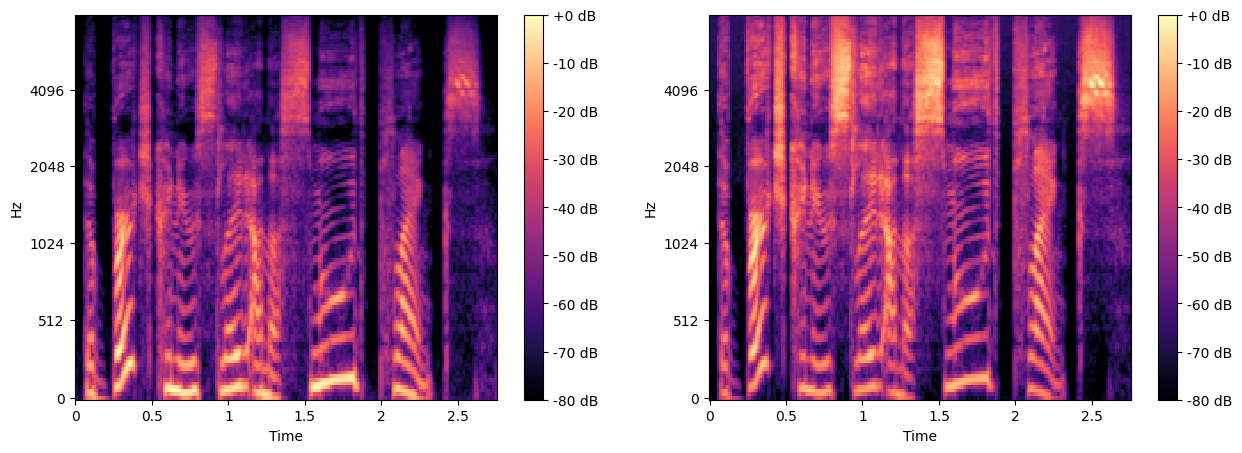

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plot_spectrogram(audio_signal, fs, fig, ax1), plot_spectrogram(pre_emph, fs, fig, ax2)

(None, None)

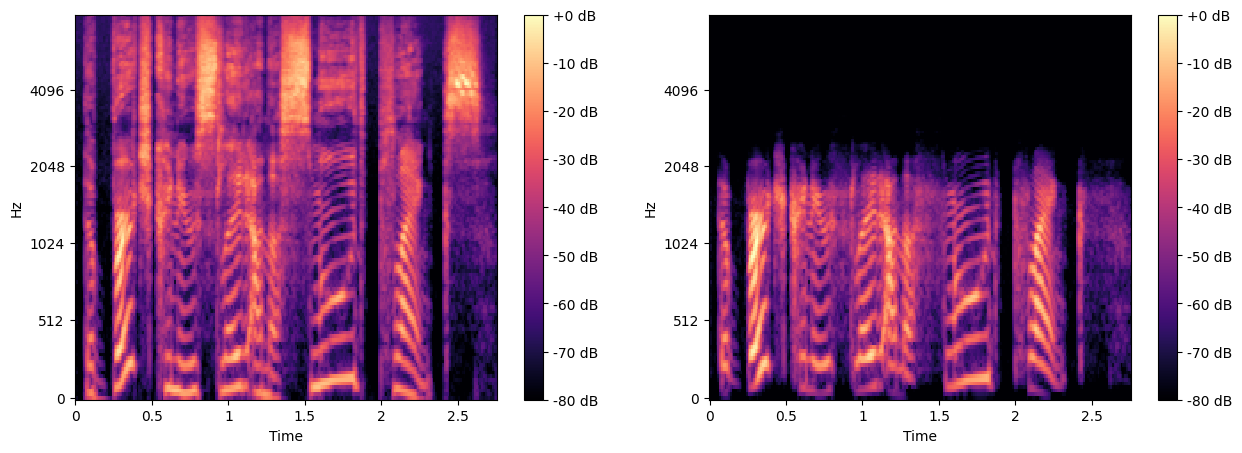

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

audio_filt = bandpass(pre_emph, fs)
plot_spectrogram(pre_emph, fs, fig, ax1), plot_spectrogram(audio_filt, fs, fig, ax2)

(0.3, 0.31)

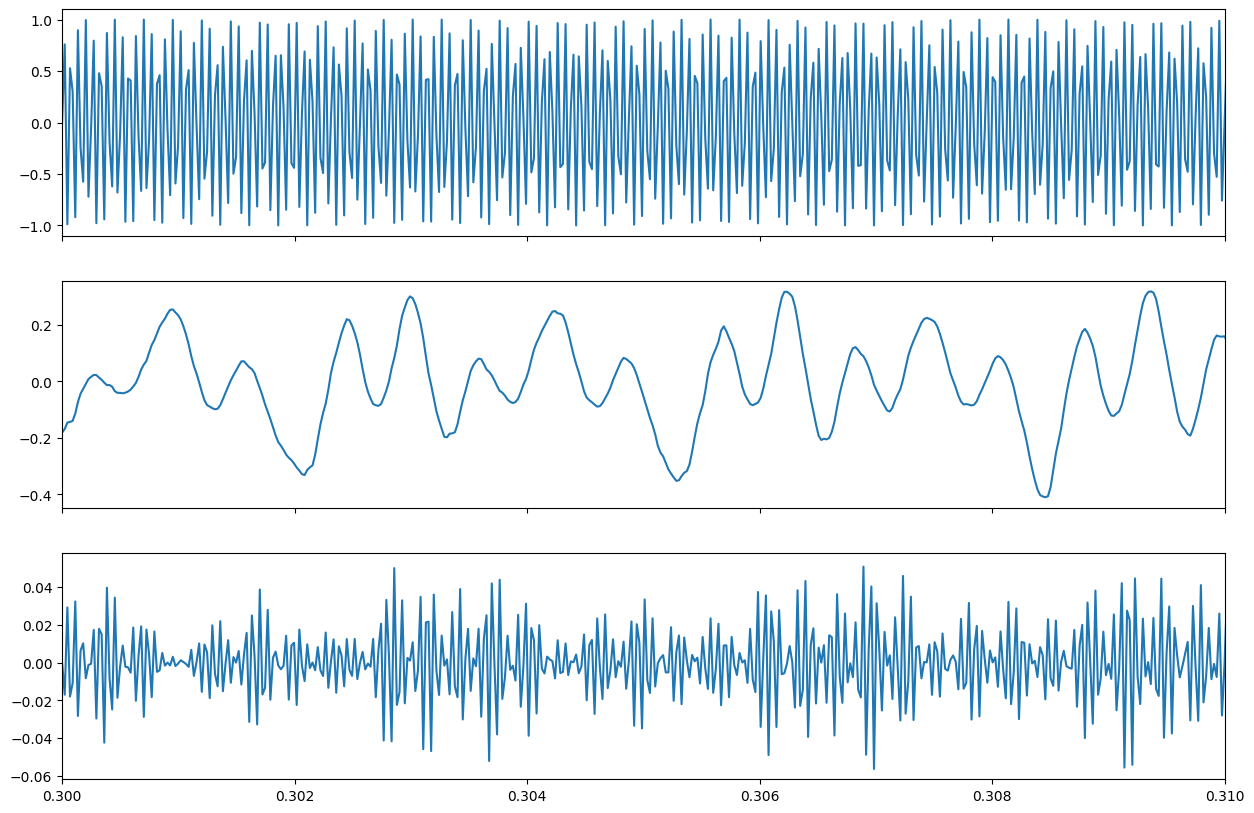

In [11]:
f = 16e3
f_carr = np.sin(2*np.pi*f*t)
f_electrode = f_carr * audio_filt
f, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

ax1.plot(t, f_carr)
ax2.plot(t, audio_signal)
ax3.plot(t, f_electrode)
ax1.set_xlim(0.3, 0.31)



(None, None)

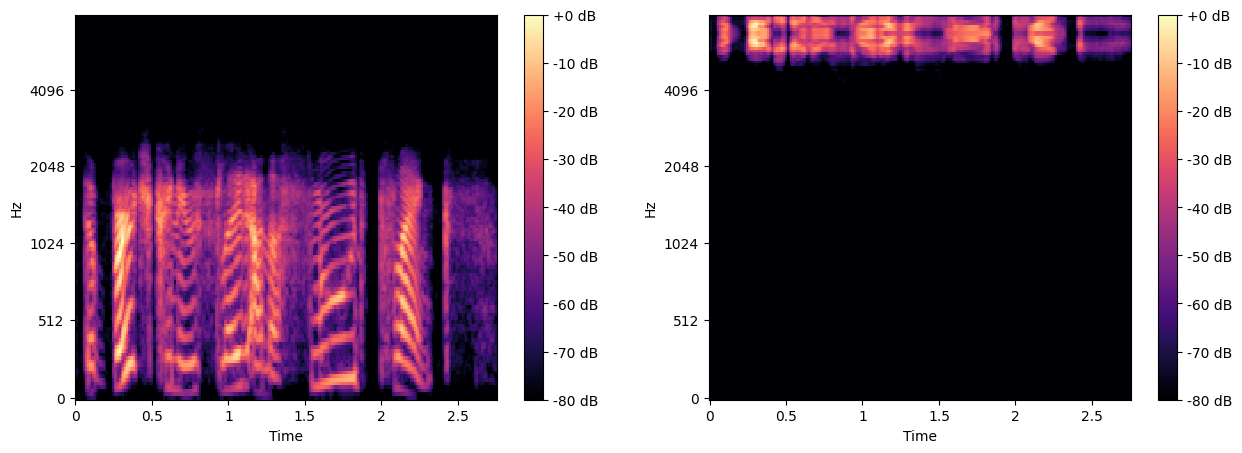

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plot_spectrogram(audio_filt, fs, fig, ax1), plot_spectrogram(f_electrode, fs, fig, ax2)

# F0-F2 Strategy

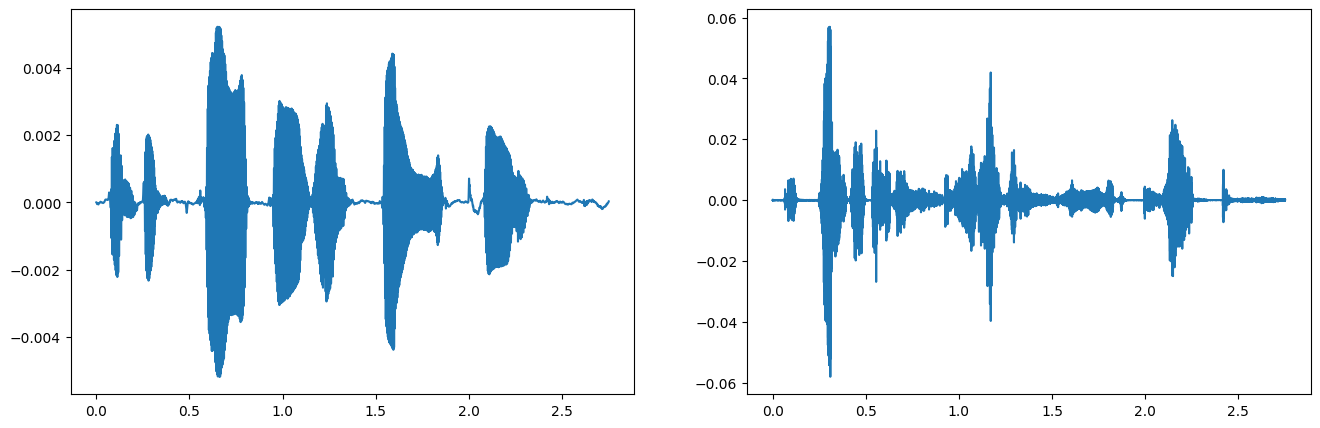

In [13]:
filter_output = np.zeros((2, n))

filter_output[0,:] = lowpass(pre_emph, fs, 270)
filter_output[1,:] = bandpass(pre_emph, fs, 1e3, 4e3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
ax1.plot(t, filter_output[0,:])
ax2.plot(t, filter_output[1,:])


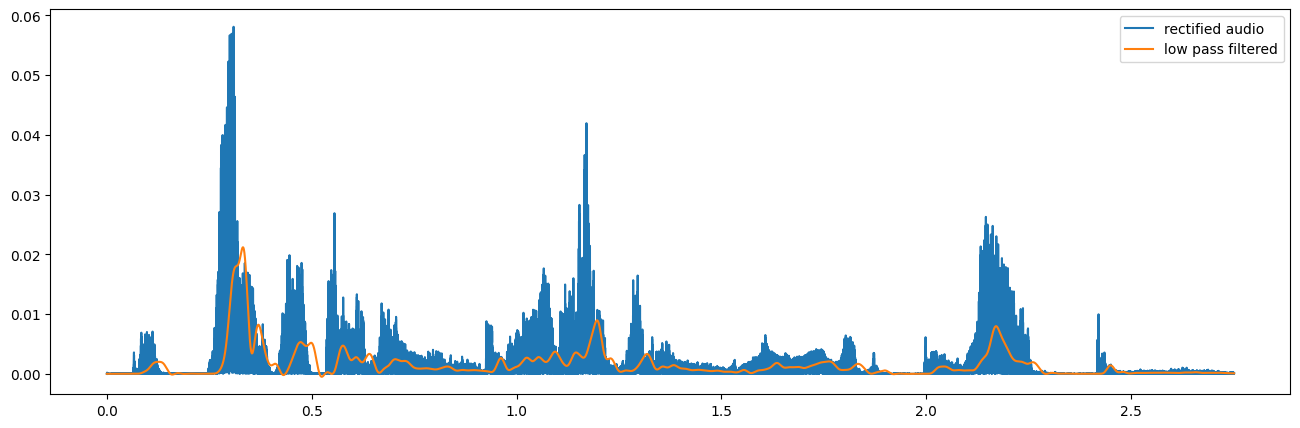

In [14]:
f, (ax1) = plt.subplots(1, 1, figsize=(16, 5))
rect_audio = abs(filter_output[1,:])
rect_low = lowpass(rect_audio, fs, 35)
ax1.plot(t, rect_audio, label="rectified audio")
ax1.plot(t, rect_low, label="low pass filtered")
ax1.legend()

In [93]:
def zero_crossings(array, size=None, offset=0):
    if size is None:
        size = len(array)

    # Take a slice of the array based on size and offset
    array_slice = array[offset:offset + size]
    
    # Get the signs of the array elements (-1, 0, 1)
    signs = np.r_[0, np.sign(array_slice)]
    
    # Find where the sign changes (i.e., consecutive elements with different signs)
    zero_crossings = np.diff(signs) != 0
    
    # Sum the number of sign changes (ignoring zero values)
    return np.sum(zero_crossings)

def freq_est_zc(array, Fs):
    array = np.asarray(array, dtype=np.float64)
    zcr = zero_crossings(array)
    f_est = zcr / len(array) * Fs / 2
    return f_est

def create_frames(signal, fs, frame_size = 25e-3, frame_stride = None):
    if frame_stride is None:
        frame_stride = frame_size * .4
        
    frame_length, frame_step = int(np.round(frame_size * fs)), int(np.round(frame_stride * fs))
    
    num_frames = int(np.ceil(np.abs(len(signal) - frame_length) / frame_step))
    pad_signal_length = int(num_frames * frame_step + frame_length)
    
    z = np.zeros(pad_signal_length - len(signal))
    padded = np.r_[signal, z]
    
    return np.lib.stride_tricks.sliding_window_view(padded, frame_length)[::frame_step][:num_frames]    
    
    
frames = create_frames(pre_emph, fs)

signal_frames_F0 = create_frames(filter_output[0,:],fs, frame_size = 25e-3)
signal_frames_F2 = create_frames(filter_output[1,:],fs, frame_size = 25e-3)
number_frames = len(signal_frames_F0)

F0_ZC = np.zeros((number_frames,1))
F2_ZC = np.zeros((number_frames,1))

for (idx,i) in enumerate(range(number_frames)):
    F0_ZC[idx] = freq_est_zc(signal_frames_F0[i,:],fs)
    F2_ZC[idx] = freq_est_zc(signal_frames_F2[i,:],fs)

zcrThreshold = 300
F0_ZC[F0_ZC > zcrThreshold] = 100


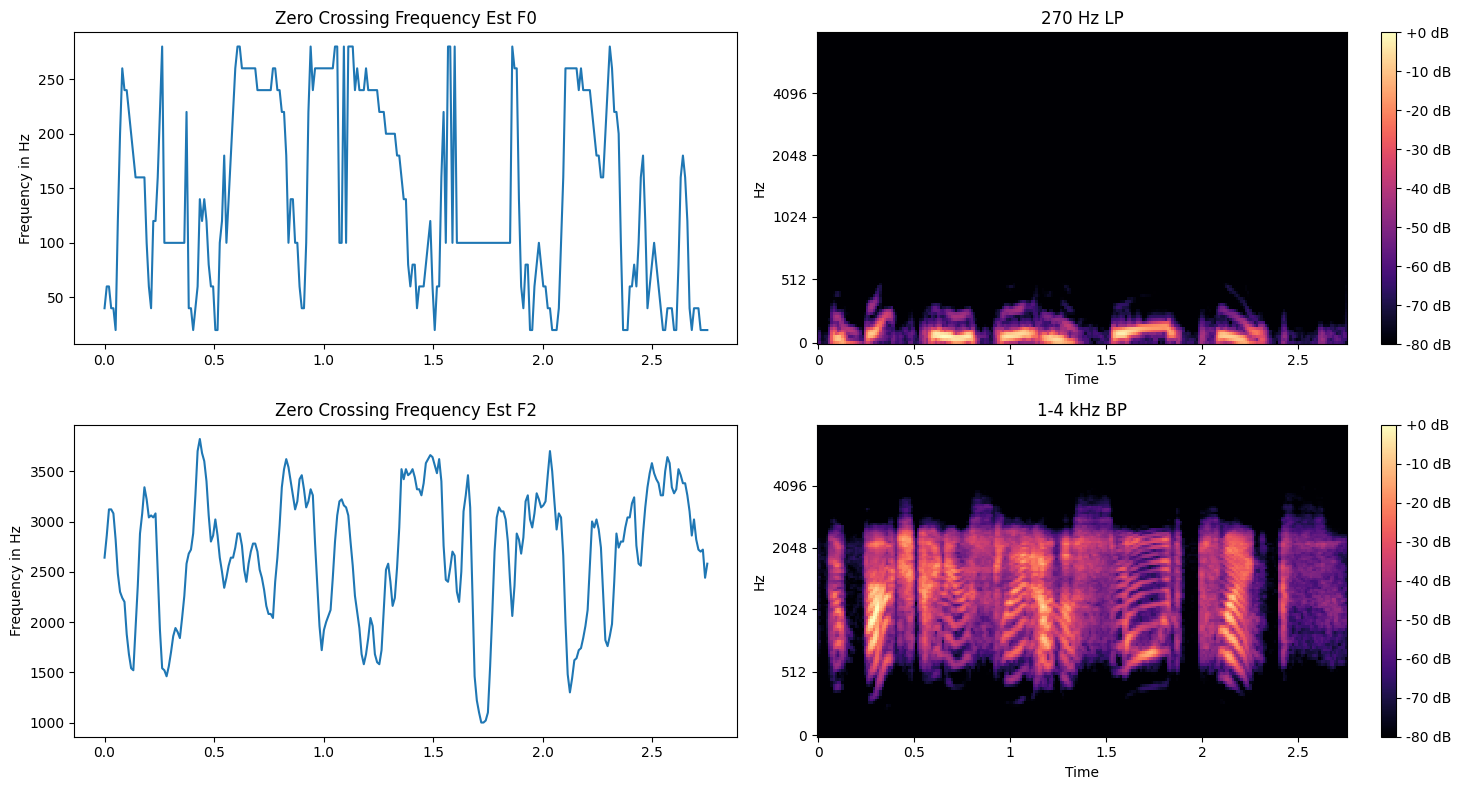

In [94]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))

time_frames = np.linspace(0, duration, number_frames)
ax1.plot(time_frames, F0_ZC.ravel())
ax1.set_title("Zero Crossing Frequency Est F0")
ax1.set_ylabel("Frequency in Hz")

plot_spectrogram(filter_output[0,:], fs, f, ax2)
ax2.set_title("270 Hz LP")

time_frames = np.linspace(0, duration, number_frames)
ax3.plot(time_frames, F2_ZC.ravel())
ax3.set_title("Zero Crossing Frequency Est F2")
ax3.set_ylabel("Frequency in Hz")

plot_spectrogram(filter_output[1,:], fs, f, ax4)
ax4.set_title("1-4 kHz BP")
plt.tight_layout()

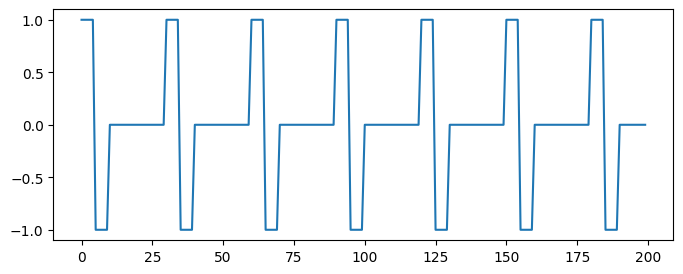

In [95]:
def biphasic_pulse(N_total, N_pulse, N_period, offset=0):
    # Calculate the number of repetitions needed
    y = np.ones(N_pulse)
    y[N_pulse // 2:] = -1

    pre_zeros = np.zeros(max(0, N_period - N_pulse))
    pulse = np.concatenate((y, pre_zeros))

    return np.tile(pulse, (N_total // N_period) + 1)[:N_total]


y_pulse = biphasic_pulse(200,10,30)

plt.figure(figsize=(8, 3))
plt.plot(y_pulse)

273 22 121349 44


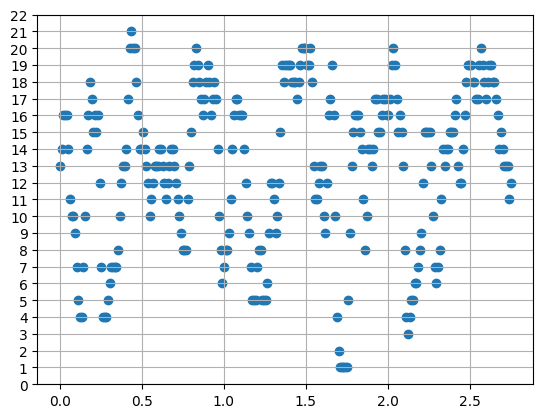

In [96]:
def pulse_generation(Fs, PulseRate, ElectrodeRate, Envelope, N_electrodes, f_low=1e3, f_high=4e3):
    # Initialize constants
    N_signal = len(Envelope)
    number_frames = PulseRate.shape[0]
    
    N_total = int(np.ceil(N_signal / number_frames))
    N_period_vec = np.round(Fs / PulseRate).astype(int)
    N_pulse = int(np.round(1e-3 * Fs))
    
    # Frequency spacing for electrodes
    delta_freq = (f_high - f_low) / N_electrodes
    frequency_spacing = np.linspace(f_low + delta_freq, f_high, N_electrodes)

    # Initialize arrays for results
    electrode_signal = np.zeros((N_electrodes, N_signal))
    electrodes = np.zeros(number_frames, dtype=int)

    # Process data in chunks
    pulses = np.zeros(N_signal)
    
    print(number_frames, N_electrodes, N_signal, N_pulse)
    
    for idx_frame in range(number_frames):
        # Compute indices for the current frame
        idx_begin = idx_frame * N_total
        idx_end = min(N_signal, idx_begin + N_total)
        idx_diff = idx_end - idx_begin
        
        N_period = N_period_vec[idx_frame]
        pulse_frame = biphasic_pulse(N_total, N_pulse, `N_period`)
        pulse_frame = Envelope[idx_begin:idx_end] * pulse_frame[:idx_diff]
        
        
        # Generate the biphasic pulse for the current frame
        pulses[idx_begin:idx_end] = pulse_frame

        # Find the minimum electrode index corresponding to the current frame
        number_electrode = np.where(ElectrodeRate[idx_frame] <= frequency_spacing)[0]
        selected_electrode = np.min(number_electrode)

        # Store the selected electrode and assign the pulse to the electrode signal
        electrodes[idx_frame] = selected_electrode
        electrode_signal[selected_electrode, idx_begin:idx_end] = pulse_frame

    return electrode_signal, electrodes, pulses, frequency_spacing

N_electrodes = 22

electrode_signal, electrodes, pulses, freq_spacing = pulse_generation(fs, F0_ZC, F2_ZC, rect_low, N_electrodes)


plt.scatter(time_frames, electrodes+1)
plt.yticks(np.arange(0, 23));
plt.grid("minor")

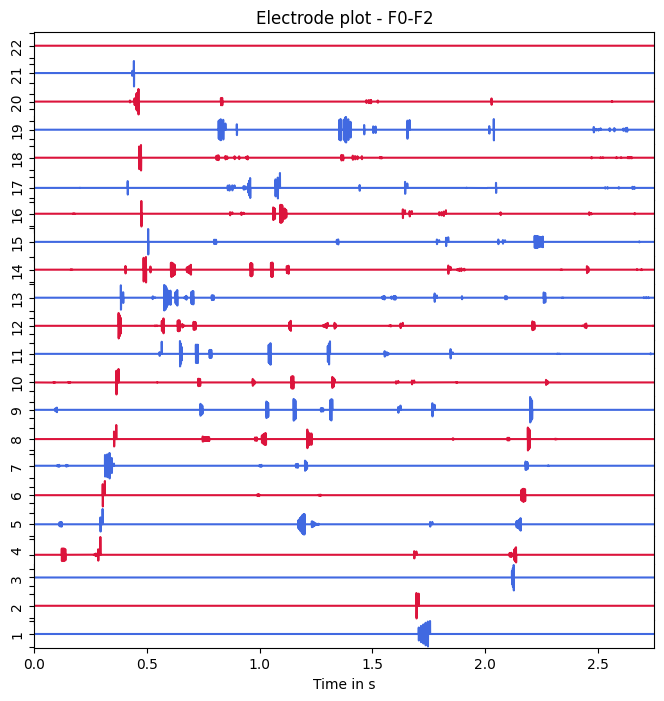

In [97]:
def plot_electrode(N_electrodes, time, electrode_signal, xlim_low=0, xlim_up=None, title="Electrode plot"):
    """
    Plots the electrode signals with stacked subplots.

    Parameters:
    - N_electrodes: Number of electrodes (int)
    - time: Time array (1D array-like)
    - electrode_signal: Electrode signal array (2D array-like with shape (N_electrodes, len(time)))
    - xlim_low: Lower bound for x-axis (default: 0)
    - xlim_up: Upper bound for x-axis (default: length of time array)
    - title: Title of the plot (default: "Electrode plot")
    """
    
    if xlim_up is None:
        xlim_up = time[-1]  # Set the upper limit of the x-axis to the last time point if not provided
    
    fig, ax = plt.subplots(N_electrodes, 1, figsize=(8, 8), sharex=True)
    
    # Set the main title
    ax[0].set_title(title)
    
    colors = ["royalblue", "crimson"]  # Define two alternating colors

    # Plot each electrode signal on its own subplot
    for i in range(N_electrodes):
        # Plot the electrode signal in reverse order (like Julia's 1-based indexing)
        ax[i].plot(time, electrode_signal[N_electrodes - 1 - i, :], color=colors[(N_electrodes - 1 - i) % 2])
        
        # Remove x-tick labels for all but the last subplot
        if i != N_electrodes - 1:
            ax[i].tick_params(labelbottom=False)
        
        # Remove y-tick labels
        ax[i].tick_params(labelleft=False)
        
        # Set the x-axis limits
        ax[i].set_xlim([xlim_low, xlim_up])
        
        # Label each subplot with its corresponding electrode number
        ax[i].set_ylabel(str(N_electrodes - i))
    
    # Set x-axis label on the last subplot
    ax[N_electrodes - 1].set_xlabel("Time in s")

    # Hide borders between subplots
    for i in range(1, N_electrodes):
        ax[i-1].spines['bottom'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
    
    plt.subplots_adjust(wspace=0, hspace=0)  # Adjust spacing between subplots
    
plot_electrode(N_electrodes,t, electrode_signal,    title="Electrode plot - F0-F2")

In [98]:
F0_ZC.shape, F2_ZC.shape, rect_low.shape

((273, 1), (273, 1), (121349,))

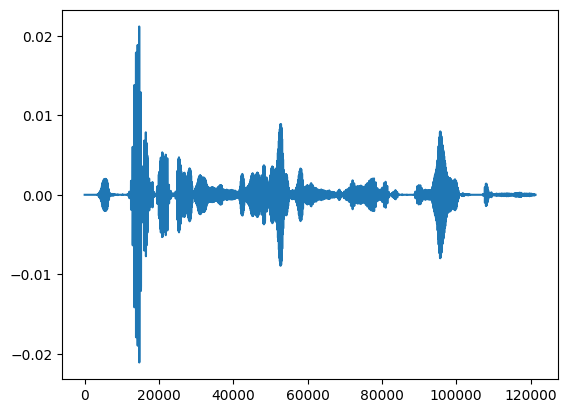

In [104]:
plt.plot(electrode_signal.sum(axis=0))